In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
#using tensorflow backend

Using TensorFlow backend.


In [3]:
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

In [4]:
def mse_custom(y_true,y_predicted):
    mse_mod = tf.math.reduce_mean(tf.math.abs(tf.subtract(y_true[3:-3],y_predicted[3:-3])))
    return mse_mod

In [5]:
def mse_custom_real(y_true,y_predicted):
    mse_mod = tf.norm(tf.subtract(y_true[3:-3],y_predicted[3:-3]))
    return mse_mod

In [6]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [7]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [8]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [9]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [10]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [11]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [12]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)
    filt_df2 = (df.fecha_inicio_sintomas < 0)
    df[filt_df2] = 0

In [13]:
data = pd.read_csv("casos/CasosCovid19_arg.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [14]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2021-01-11 00:00:00
ultima apertura de persona confirmada:  2021-01-11 00:00:00


In [15]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)
fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]

In [16]:
aw = np.zeros(6) + 1
pop = 100000
rep_fun = repratio_t_conv
r_def,a_t = risk_diagram(fecha_sintomas,pop,aw,rep_fun,ret=True) #hasta aca perfecto
a_t = a_t[10:] 
a = a_t[:-4]

In [17]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
casos_por_dia = sum_last14(casos_por_dia)
casos_por_dia = casos_por_dia[17:,1]
b = np.zeros(casos_por_dia.shape[0]+3,dtype=float)
b[:casos_por_dia.shape[0]] = casos_por_dia

In [18]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
n_t = np.copy(casos_por_dia)
prox_dia = max(fecha_sintomas) + 1
#completing the values for the rest of the values of n_t
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = prox_dia + i
    aux[1] = np.mean(n_t[prox_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
dias = np.copy(n_t[:,0]).astype(int)
dias = dias[dias>=10]
dias = dias[dias<=max(fecha_sintomas)-4]
m1 = np.zeros((dias.shape[0],3)) #denominator of r7 expression
m2 = np.zeros((dias.shape[0],3)) #numerator of r7 expression

In [19]:
for i in dias:
    m1[i-10,:] = n_t[i-6:i-3,1]
    m2[i-10,:] = n_t[i-1:i+2,1]

In [20]:
n_dias = m1.shape[0]

In [21]:
def my_matrix(shape):
    m = np.zeros((shape,shape))
    i = 3
    while i < shape-3:
        m[i,i-3:i+4] = 1/7
        i = i + 1
    return m

In [22]:
def ret_matrix(shape):
    numpyA = my_matrix(shape)
    numpyA = keras.backend.variable(numpyA)
    mat = numpyA
    return mat

In [23]:
n_dias = m1.shape[0]

In [24]:
#m1 += np.random.normal(0,25,m1.shape)
#m2 += np.random.normal(0,25,m2.shape)

In [25]:
m1.shape == m2.shape

True

In [26]:
mat = ret_matrix(n_dias)

In [27]:
pop = 45376763 #poblacion en cuestion

iteracion numero 0
[array([[2.8828075 ],
       [0.10870421],
       [0.01124826]], dtype=float32)]


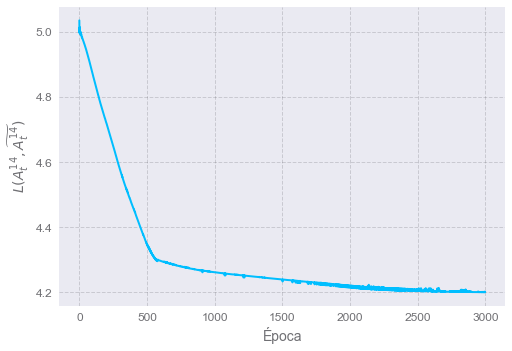

iteracion numero 1
[array([[2.835225  ],
       [0.12492013],
       [0.04398615]], dtype=float32)]


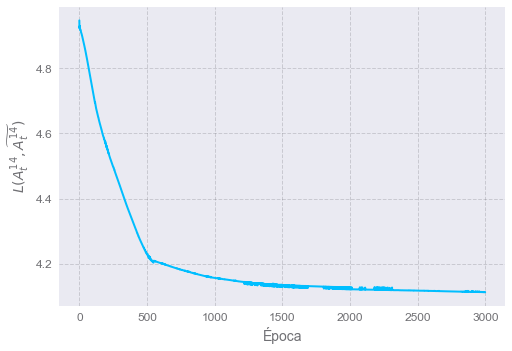

iteracion numero 2
[array([[2.933895  ],
       [0.01207967],
       [0.054325  ]], dtype=float32)]


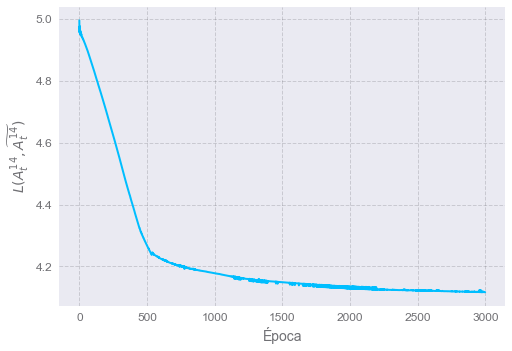

iteracion numero 3
[array([[2.7420542 ],
       [0.24711823],
       [0.01327152]], dtype=float32)]


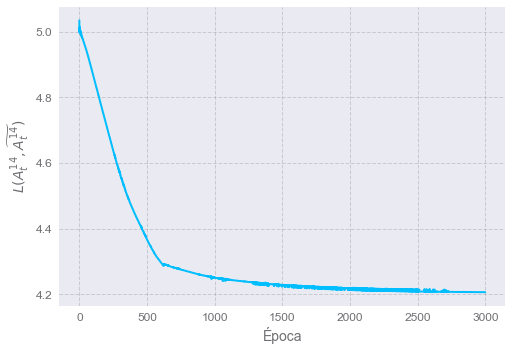

iteracion numero 4
[array([[2.7769375 ],
       [0.16250376],
       [0.06123603]], dtype=float32)]


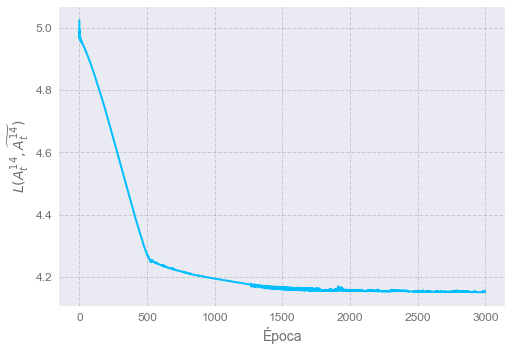

iteracion numero 5
[array([[2.8466551 ],
       [0.05253027],
       [0.106971  ]], dtype=float32)]


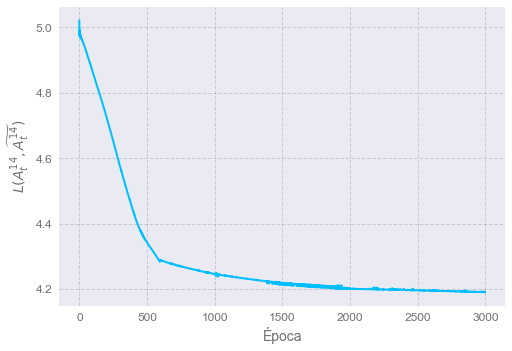

iteracion numero 6
[array([[2.7283254 ],
       [0.21936162],
       [0.05228661]], dtype=float32)]


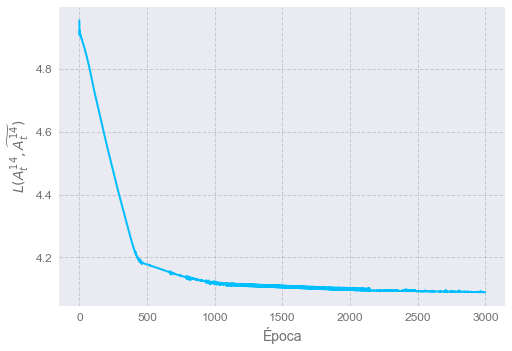

iteracion numero 7
[array([[2.7236636 ],
       [0.1941771 ],
       [0.08187602]], dtype=float32)]


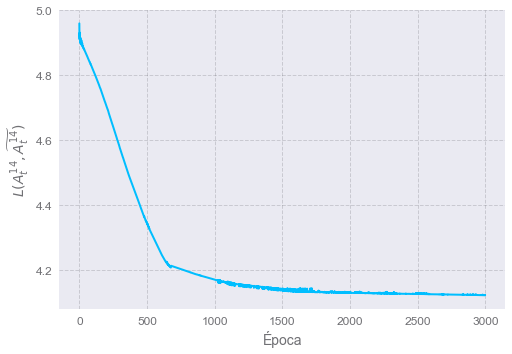

iteracion numero 8
[array([[2.6421194 ],
       [0.35812747],
       [0.00270167]], dtype=float32)]


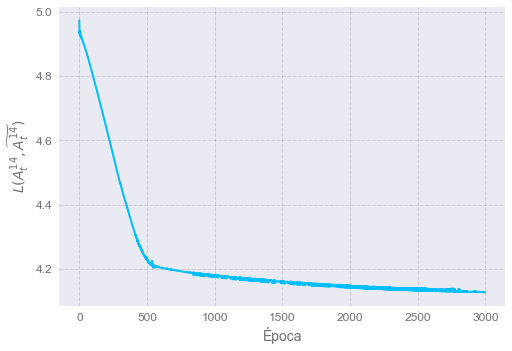

iteracion numero 9
[array([[2.8525572 ],
       [0.1098657 ],
       [0.03769342]], dtype=float32)]


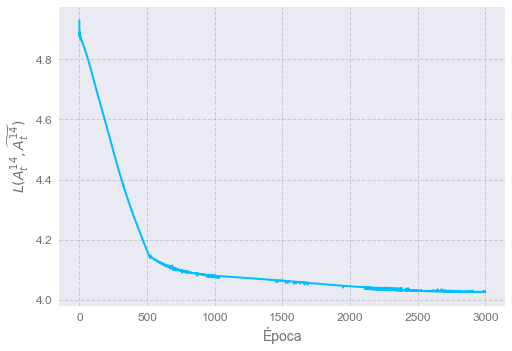

In [28]:
import random as python_random
matrix = np.empty((10,3),dtype=float)
for j in range(10):
    print('iteracion numero',j)
    data = pd.read_csv("casos/CasosCovid19_arg.txt",sep=",",quotechar='"',
                       parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    #print("primer sintoma de persona confirmada: ",inicio_epidemia)
    #print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
    #print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]
    aw = np.zeros(6) + 1
    pop = 100000
    rep_fun = repratio_t_conv
    r_def,a_t = risk_diagram(fecha_sintomas,pop,aw,rep_fun,ret=True) #hasta aca perfecto
    a_t = a_t[10:] 
    a = a_t[:-4]
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_por_dia = sum_last14(casos_por_dia)
    casos_por_dia = casos_por_dia[17:,1]
    b = np.zeros(casos_por_dia.shape[0]+3,dtype=float)
    b[:casos_por_dia.shape[0]] = casos_por_dia
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia)
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    dias = np.copy(n_t[:,0]).astype(int)
    dias = dias[dias>=10]
    dias = dias[dias<=max(fecha_sintomas)-4]
    m1 = np.zeros((dias.shape[0],3)) #denominator of r7 expression
    m2 = np.zeros((dias.shape[0],3)) #numerator of r7 expression
    for i in dias:
        m1[i-10,:] = np.copy(n_t[i-6:i-3,1])
        m2[i-10,:] = np.copy(n_t[i-1:i+2,1])
    n_dias = m1.shape[0]
    #m1 += np.random.normal(0,5,m1.shape)
    #m2 += np.random.normal(0,5,m2.shape)
    mat = ret_matrix(n_dias)
    pop = 45376763 #poblacion en cuestion
    input_1 = keras.layers.Input(shape=(3,))
    input_2 = keras.layers.Input(shape=(3,))
    input_3 = keras.layers.Input(shape=(1,))
    initializer = keras.initializers.Ones() #the vector of weights a
    l_input_1 = keras.layers.Dense(1,activation='relu',kernel_initializer=initializer,use_bias=False,kernel_constraint=tf.keras.constraints.NonNeg())(input_1)
    l_input_2 = keras.layers.Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
    division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, tf.math.minimum(inputs[1]/inputs[0],4), inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
    mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
    cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
    model = keras.Model(inputs=[input_1,input_2,input_3],outputs=[cases])
    optimizer = keras.optimizers.Adam(5e-3)
    model.compile(optimizer, loss=mse_custom)
    history = model.fit([m1,m2,a*(100000/pop)], b*(100000/pop), epochs=3000, batch_size=n_dias,shuffle=False,verbose=0)
    first_layer_weights = model.layers[2].get_weights()
    matrix[j,:] = np.array(first_layer_weights).flatten()
    print(first_layer_weights)
    plt.plot(history.history['loss'])
    plt.xlabel('Época')
    plt.ylabel(r'$L(A_{t}^{14},\widetilde{A_{t}^{14}})$')
    plt.savefig('loss_example'+str(j)+'.pdf',bbox_inches='tight')
    plt.show()

In [30]:
means = np.mean(matrix,axis=0)
std = np.std(matrix,axis=0)
print(means)
print(std/np.sqrt(10))

[2.79642401 0.15893882 0.04655957]
[0.02657391 0.03022192 0.00978214]
